In [1]:
%matplotlib widget
from bmcs_cross_section.api import MKappa, EC2
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sig_c1, sig_c2, sig_c3, eps_cu1, b, c, d, A_f, f_fu, E_f = \
 sp.symbols('sigma_c1 sigma_c2 sigma_c3, varepsilon_cu1, b, c, d, A_f, f_{fu}, E_f', real=True, nonnegative=True)
eps_cy, eps_cu, eps, E_cc, f_cm = \
sp.symbols('varepsilon_cy, varepsilon_cu, varepsilon, E_cc, f_cm', real=True, nonnegative=True)

In [7]:
E_cc_1 = f_cm / eps_cy

sig_c_eps_1 = sp.Piecewise(
        (E_cc_1 * eps, eps < eps_cy),
         (f_cm, eps < eps_cu),
        (0, True)
)

sig_c_eps_1

Piecewise((f_cm*varepsilon/varepsilon_cy, varepsilon < varepsilon_cy), (f_cm, varepsilon < varepsilon_cu), (0, True))

In [3]:
# EC2, eq. (3.14)

k = 1.05 * E_cc * eps_cy / f_cm
eta = eps / eps_cy
sig_c = f_cm * (k*eta - eta**2)/(1+eta*(k-2))

sig_c_eps_2 = sp.Piecewise(
        (0, eps > eps_cu),
        (sig_c, eps > 0),
        (0, True)
)
sig_c_eps_2

Piecewise((0, varepsilon > varepsilon_cu), (f_cm*(1.05*E_cc*varepsilon/f_cm - varepsilon**2/varepsilon_cy**2)/(varepsilon*(1.05*E_cc*varepsilon_cy/f_cm - 2)/varepsilon_cy + 1), varepsilon > 0), (0, True))

area_diff [%]= 2.42
area_diff [%]= 1.66
area_diff [%]= 0.9
area_diff [%]= -0.08
area_diff [%]= -1.08
area_diff [%]= -2.09
area_diff [%]= -3.12
area_diff [%]= -4.18
area_diff [%]= -5.25
area_diff [%]= 1.04
area_diff [%]= 4.79
area_diff [%]= 8.56
area_diff [%]= 9.92
area_diff [%]= 11.54
area_diff [%]= 13.16


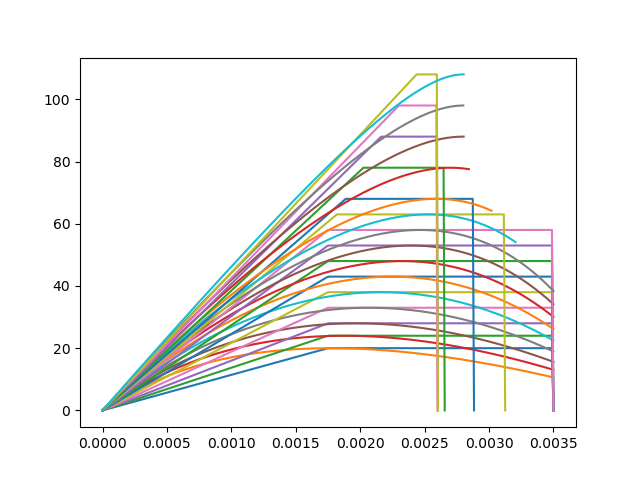

In [22]:
fig, ax = plt.subplots()
f_cms = np.array([ 20.,  24.,  28.,  33.,  38.,  43.,  48.,  53.,  58.,  63.,  68., 78.,  88.,  98., 108.])

for f_cm_ in f_cms: # f_cms:
    eps_cy_ = EC2.get_eps_c3(f_cm_ - 8)
    eps_cu_ = EC2.get_eps_cu3(f_cm_ - 8)
    sig_c_eps = sig_c_eps_1.subs({eps_cy:eps_cy_, f_cm:f_cm_, eps_cu:eps_cu_})
    get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
    eps_1 = np.linspace(0, eps_cu_, 300)
    sig_1 = get_sig(eps_1)
    
    eps_cy_ = EC2.get_eps_c1(f_cm_ - 8)
    eps_cu_ = EC2.get_eps_cu1(f_cm_ - 8)
    sig_c_eps2 = sig_c_eps_2.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
                                f_cm:EC2.get_f_cm(f_cm_ - 8), eps_cu:eps_cu_})
    get_sig2 = sp.lambdify(eps, sig_c_eps2, 'numpy')
    eps_2 = np.linspace(0, eps_cu_, 300)
    sig_2 = get_sig2(eps_2)
    
    area_1 = np.trapz(y=sig_1, x=eps_1)
    area_2 = np.trapz(y=sig_2, x=eps_2)
#     print('area_1=', area_1)
#     print('area_2=', area_2)
    print('area_diff [%]=', np.round((area_2 - area_1) * 100 / area_2, 2))
    
    ax.plot(eps_1, sig_1)
    ax.plot(eps_2, sig_2)
    
# fig.show()

## Deriving $\psi_c, M_n$ equations for the linearized curve

In [43]:
substitute_E_cc_and_eps_cy = False

if substitute_E_cc_and_eps_cy:
    eps_c3 = sp.Piecewise(
            (1.75 + 0.55 * ((f_ck - 50) / 40), f_ck > 50),
            (1.75, True)
    )
else:
    eps_c3 = eps_cy

sig_line = sp.Line(sp.Point(0, 0), sp.Point(eps_c3, f_cm))

sig_eq_ = sig_line.equation(x=eps, y=sig_c1)
sig_eq = sp.solve(sig_eq_, sig_c1)[0]
sig_eq

f_cm*varepsilon/varepsilon_cy

In [44]:
sig_eq_area_up_to_eps = sp.integrate(sp.simplify(sig_eq), eps)
sig_eq_area_up_to_eps

f_cm*varepsilon**2/(2*varepsilon_cy)

In [45]:
# Compare F_t = A_f * f_fu with F_c_1, if F_t <= F_c_1, then use psi_c formula, otherwise psi_c = 1
eps_fu = f_fu/E_f
c_1 = d * (eps_c3 / (eps_c3 + eps_fu))
F_c_1 = sig_eq_area_up_to_eps.subs({eps:eps_c3}) * (c_1 / eps_c3) * b
F_c_1 = sp.simplify(F_c_1)
F_c_1

E_f*b*d*f_cm*varepsilon_cy/(2*(E_f*varepsilon_cy + f_{fu}))

In [59]:
sp.N(F_c_1.subs({f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, A_f:20, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8)}))

285241.176631801

In [50]:
# Solving eps top for part 1
def get_eps_top_solved():
    c = d * eps/(eps + eps_fu)
    F_t = A_f * f_fu
    sig_z_area = sig_eq_area_up_to_eps * (c / eps)
    F_c = sig_z_area * b
    eps_top_solved = sp.solve(F_t - F_c, eps)[1] # TODO, this the positive solution, make sure you don't want the negative
    eps_top_solved = sp.simplify(eps_top_solved)
    return eps_top_solved

In [51]:
eps_part_1 = get_eps_top_solved()
eps_part_1

f_{fu}*(sqrt(A_f)*sqrt(varepsilon_cy)*sqrt(A_f*E_f*varepsilon_cy + 2*b*d*f_cm) + A_f*sqrt(E_f)*varepsilon_cy)/(sqrt(E_f)*b*d*f_cm)

In [52]:
def get_psi():
    eps_top_solved = get_eps_top_solved()
    sig_c_max = sig_eq.subs({eps: eps_top_solved})
    psi_c = sig_c_max / f_cm
    psi_c = sp.simplify(psi_c)
    return psi_c

In [53]:
psi_c = get_psi()
psi_c

sqrt(A_f)*f_{fu}*sqrt(A_f*E_f*varepsilon_cy + 2*b*d*f_cm)/(sqrt(E_f)*b*d*f_cm*sqrt(varepsilon_cy)) + A_f*f_{fu}/(b*d*f_cm)

In [54]:
psi_c_reduced = sp.cse(psi_c)
psi_c_reduced[-1][0]

sqrt(A_f)*x0*sqrt(A_f*E_f*varepsilon_cy + 2*b*d*f_cm)/(sqrt(E_f)*sqrt(varepsilon_cy)) + A_f*x0

In [55]:
sp.N(psi_c.subs({f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, A_f:20, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8)}))

0.398213469687432

In [56]:
# Because first part is triangle, the center of it is
c = d * eps/(eps + eps_fu)
ce1 = c.subs({eps: eps_part_1}) / 3
ce1 = sp.simplify(ce1)
ce1

E_f*d*(sqrt(A_f)*sqrt(varepsilon_cy)*sqrt(A_f*E_f*varepsilon_cy + 2*b*d*f_cm) + A_f*sqrt(E_f)*varepsilon_cy)/(3*(sqrt(E_f)*b*d*f_cm + E_f*(sqrt(A_f)*sqrt(varepsilon_cy)*sqrt(A_f*E_f*varepsilon_cy + 2*b*d*f_cm) + A_f*sqrt(E_f)*varepsilon_cy)))

In [57]:
# Valid for f_cm > 88
M_n_1 = sp.simplify(A_f * f_fu * (d - ce1))
M_n_1
# packaging common terms
# sp.cse(M_n)

A_f*d*f_{fu}*(3*sqrt(E_f)*b*d*f_cm + 2*E_f*(sqrt(A_f)*sqrt(varepsilon_cy)*sqrt(A_f*E_f*varepsilon_cy + 2*b*d*f_cm) + A_f*sqrt(E_f)*varepsilon_cy))/(3*(sqrt(E_f)*b*d*f_cm + E_f*(sqrt(A_f)*sqrt(varepsilon_cy)*sqrt(A_f*E_f*varepsilon_cy + 2*b*d*f_cm) + A_f*sqrt(E_f)*varepsilon_cy)))

In [58]:
sp.N(M_n_1.subs({f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, A_f:20, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8)}) / 1e6)

8.79073200763715